## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [388]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [389]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [390]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [391]:
data_set = pd.read_feather("financials_against_return.feather")
data_set

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227154,SMSI,2020-12-31,0.1703,0.010,0.224,-0.352,25.7540,0.000,-2.428,0.153,...,3.900329,0.183500,0.951683,-1.156062,-1.252562,-0.328138,-0.209308,155.732110,67.41244,NaN
227157,COOP,2020-12-31,NaN,1277.000,38.000,-1878.000,NaN,-4555.000,-228.000,3766.000,...,5.536232,0.361734,0.526816,-1.000000,1.000000,NaN,NaN,675.415520,873.30330,NaN
227162,AC,2020-12-31,0.0081,-3.262,2.720,-7.280,39.5090,-0.654,-13.804,16.062,...,0.075000,-0.145102,-0.166645,-3.960837,-3.597568,0.044353,-0.599536,685.504833,918.31667,NaN
227164,CRON,2020-12-31,0.0089,-1.276,-17.661,-37.773,1289.7890,0.000,-4.724,23.823,...,-7.403870,0.967116,2.854353,-1.103481,-8.328635,0.403737,4.525737,1943.744040,3205.92609,NaN


In [392]:
data_set.columns.to_list()

['Ticker',
 'date',
 'AssetTurnover',
 'CashFlowFromFinancialActivities',
 'CashFlowFromInvestingActivities',
 'CashFlowFromOperatingActivities',
 'CashOnHand',
 'ChangeInAccountsPayable',
 'ChangeInAccountsReceivable',
 'ChangeInAssetsLiabilities',
 'ChangeInInventories',
 'CommonStockDividendsPaid',
 'CommonStockNet',
 'ComprehensiveIncome',
 'CostOfGoodsSold',
 'CurrentRatio',
 'DaysSalesInReceivables',
 'DebtIssuanceRetirementNet_minus_Total',
 'DebtEquityRatio',
 'EBIT',
 'EBITMargin',
 'EBITDA',
 'EBITDAMargin',
 'FinancialActivities_minus_Other',
 'GoodwillAndIntangibleAssets',
 'GrossMargin',
 'GrossProfit',
 'IncomeAfterTaxes',
 'IncomeFromContinuousOperations',
 'IncomeFromDiscontinuedOperations',
 'IncomeTaxes',
 'Inventory',
 'InventoryTurnoverRatio',
 'InvestingActivities_minus_Other',
 'LongTermDebt',
 'Long_minus_TermInvestments',
 'Long_minus_termDebtCapital',
 'NetAcquisitionsDivestitures',
 'NetCashFlow',
 'NetChangeInIntangibleAssets',
 'NetChangeInInvestments_minus_

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [393]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [394]:
data_set.shape

(170483, 145)

Create the target:

In [395]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [396]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [397]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] < pd.to_datetime(test_execution_date) - pd.Timedelta(730, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [398]:
diff_2_year_cols = [x for x in data_set.columns if x.find("2_")!=-1]
#mistake sp500_change_730 not included

def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_730",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [399]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [400]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


In [401]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [402]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
feature_importance = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [403]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [404]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [405]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

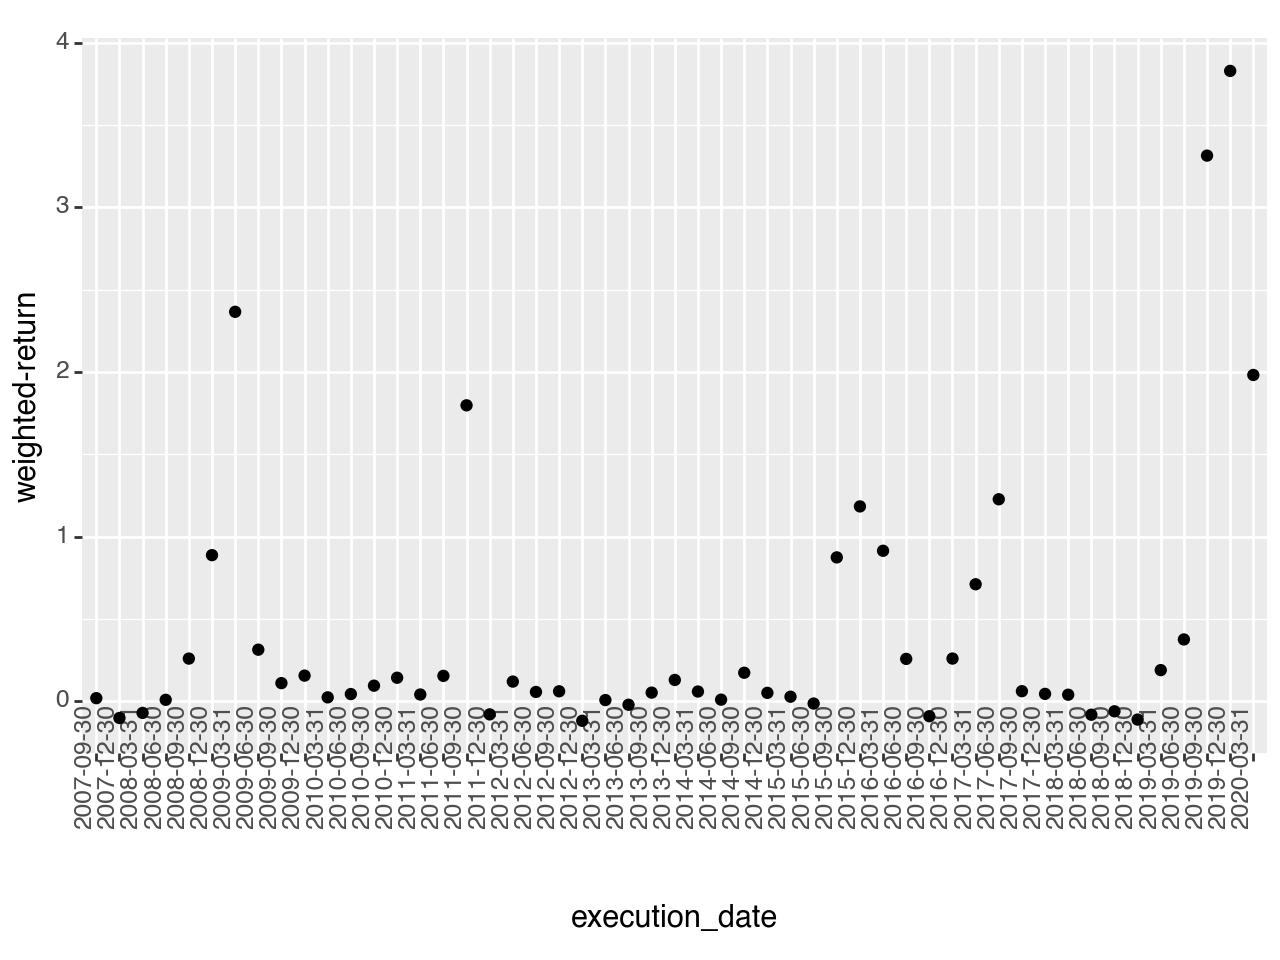

<Figure Size: (640 x 480)>

In [406]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



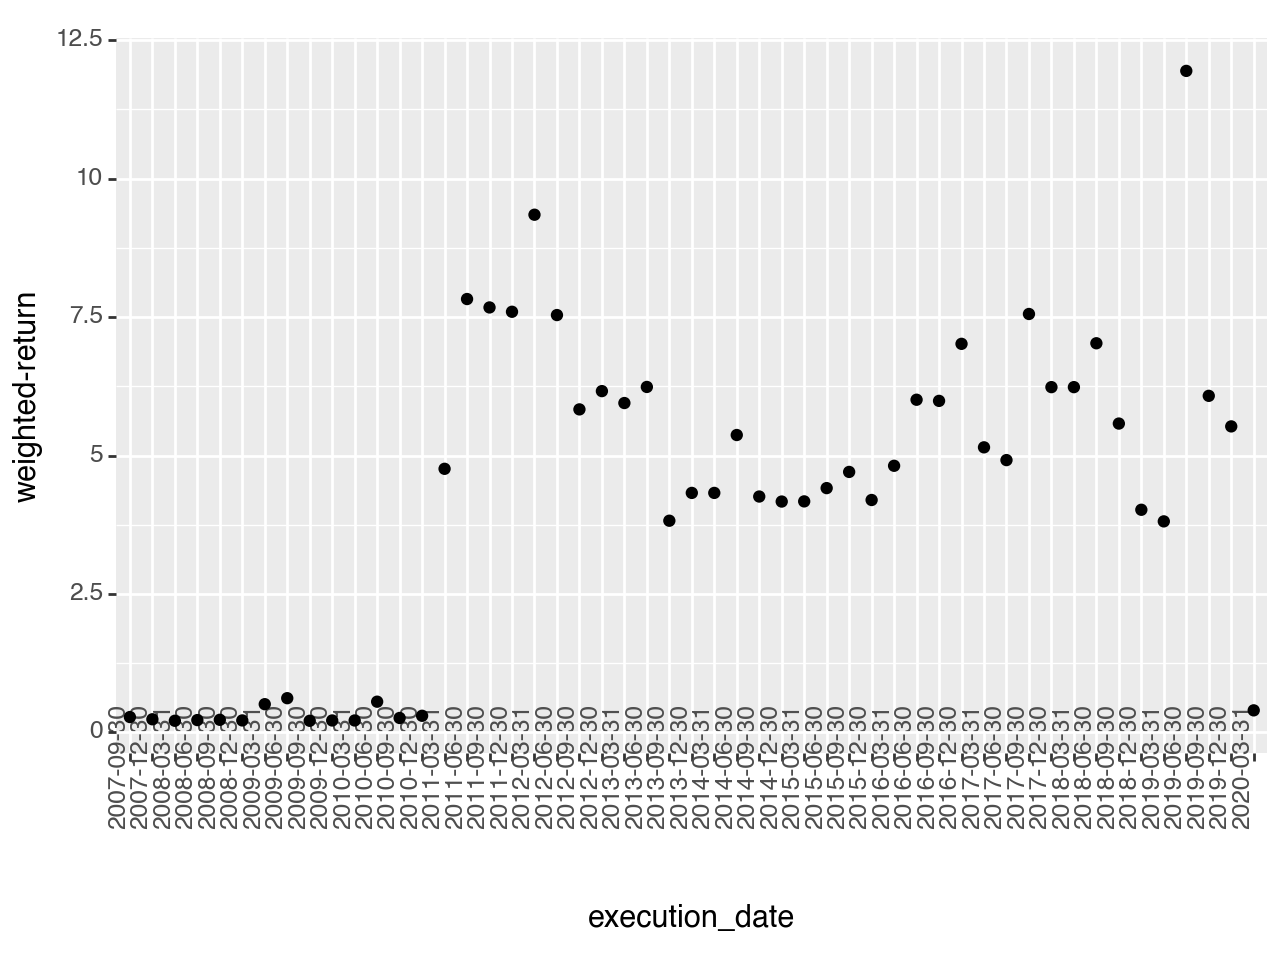

<Figure Size: (640 x 480)>

In [407]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [408]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

### First Issue: Data Leakeage

If we check the features being used there is data leakage as we are including features that measure 2 year changes but the test set is only 1 year away from the training set. We will remove those features.

In [409]:
diff_2_year_cols

['EPS_minus_EarningsPerShare_change_2_years',
 'FreeCashFlowPerShare_change_2_years',
 'OperatingCashFlowPerShare_change_2_years',
 'EBITDA_change_2_years',
 'EBIT_change_2_years',
 'Revenue_change_2_years',
 'NetCashFlow_change_2_years',
 'CurrentRatio_change_2_years']

I have modified the code so that I can get the feature importance of each execution date

In [410]:
print(len(all_models.keys()))

51


In [411]:
for index, i in enumerate(all_models.keys()):
    if index == 51:
        try:
            print(draw_feature_importance(all_models[np.datetime64(i)]))
        except:
            continue

Now after changing the test period to 730 days and removing sp500_change_720 the important features seem better.

In [425]:
import shap

def run_single_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        test_set.reset_index(inplace=True,drop=True)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        print(train_size)
        print(test_size)
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date

        return evals_result,predicted_tickers,all_models,model,X_train,X_test

evals_result,predicted_tickers,all_models,model,X_train,X_test = run_single_model_for_execution_date('2020-03-31T00:00:00.000000000',all_results,all_predicted_tickers_list,all_models,n_trees,False)

95219
3529


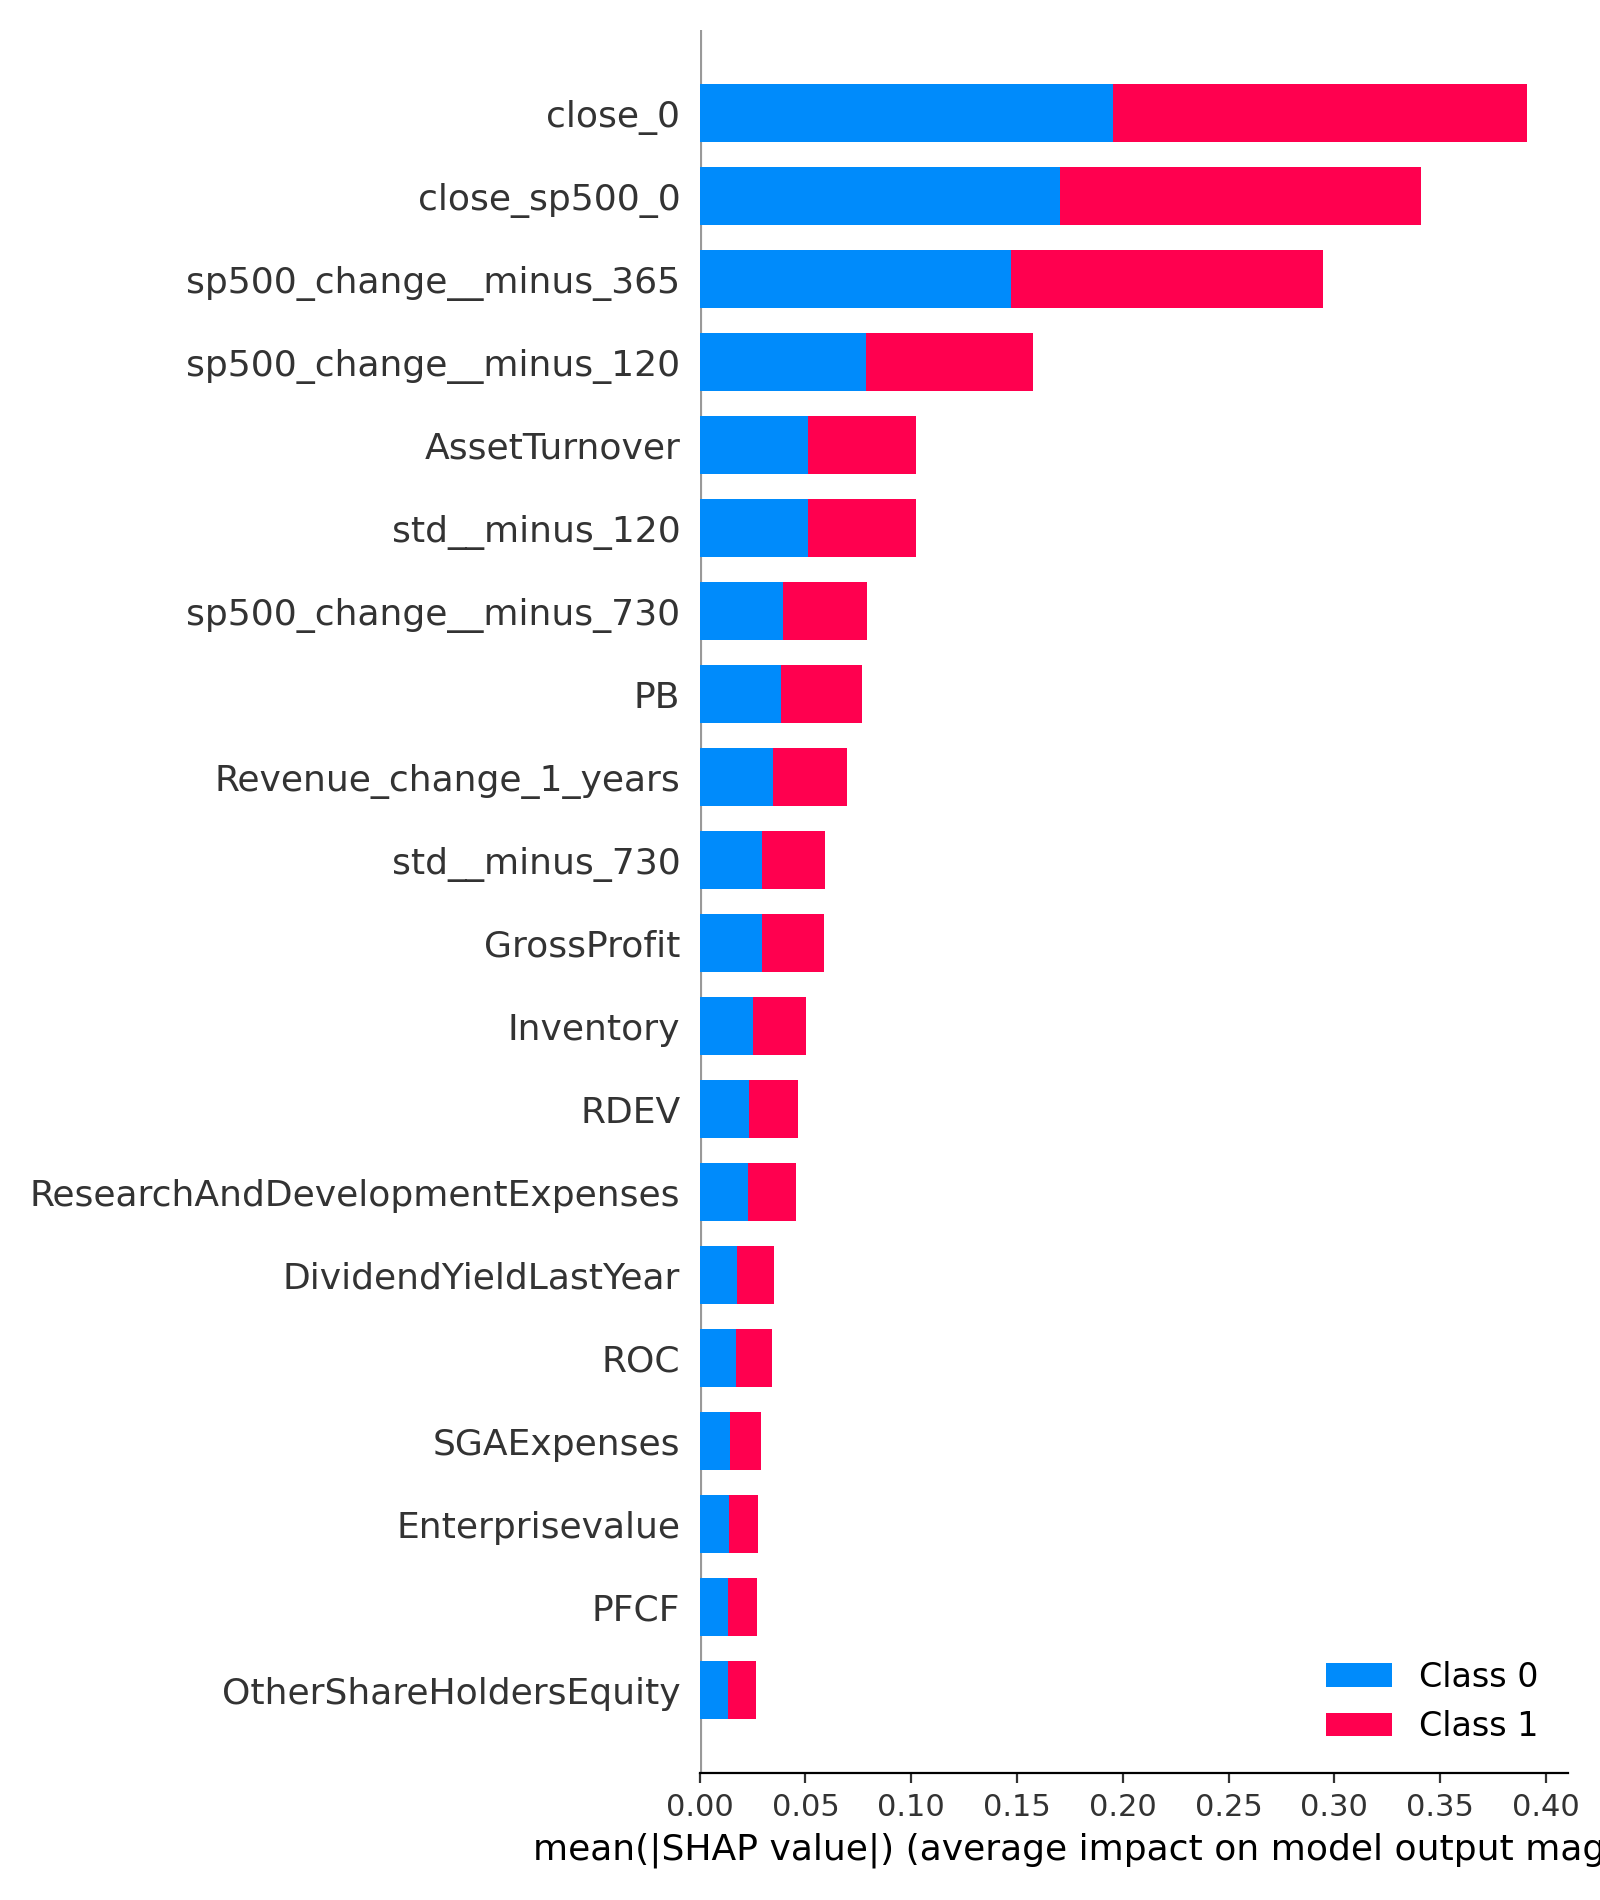

In [413]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

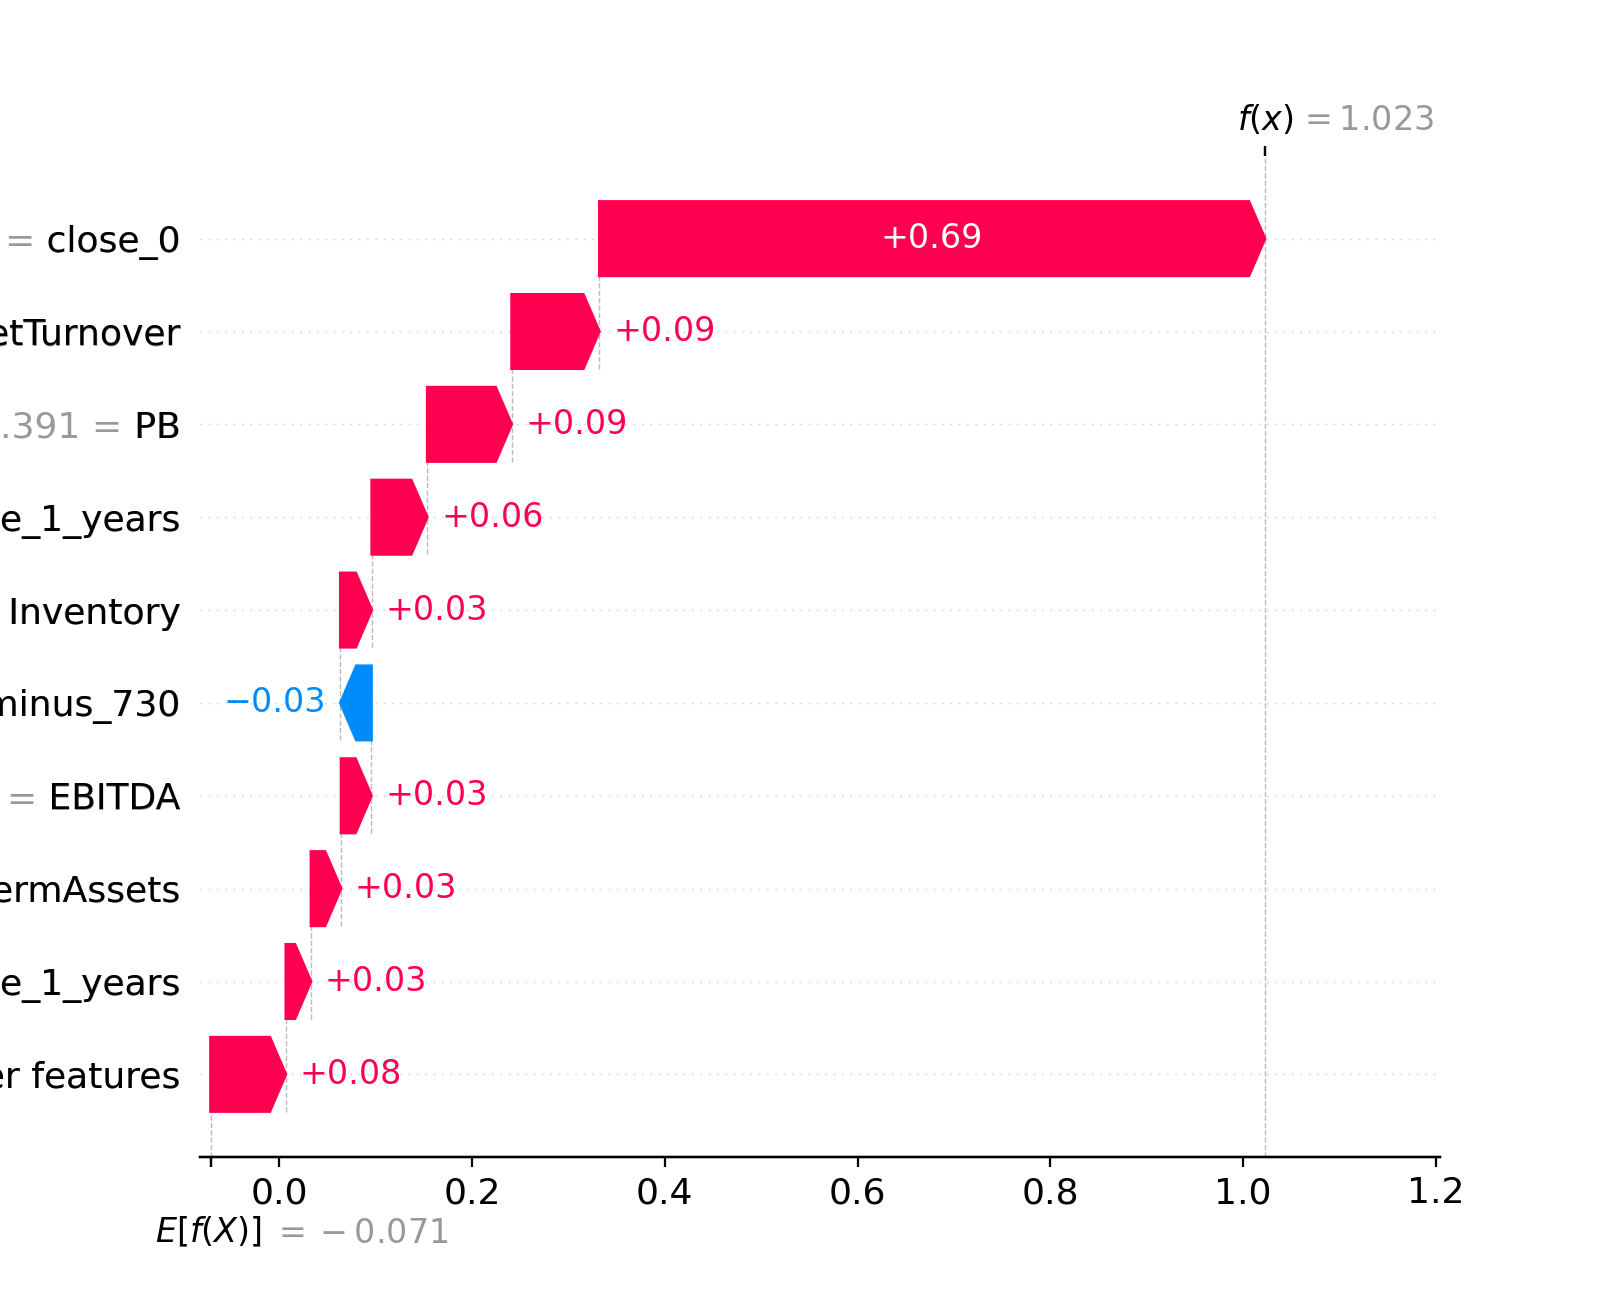

<Figure size 500x500 with 0 Axes>

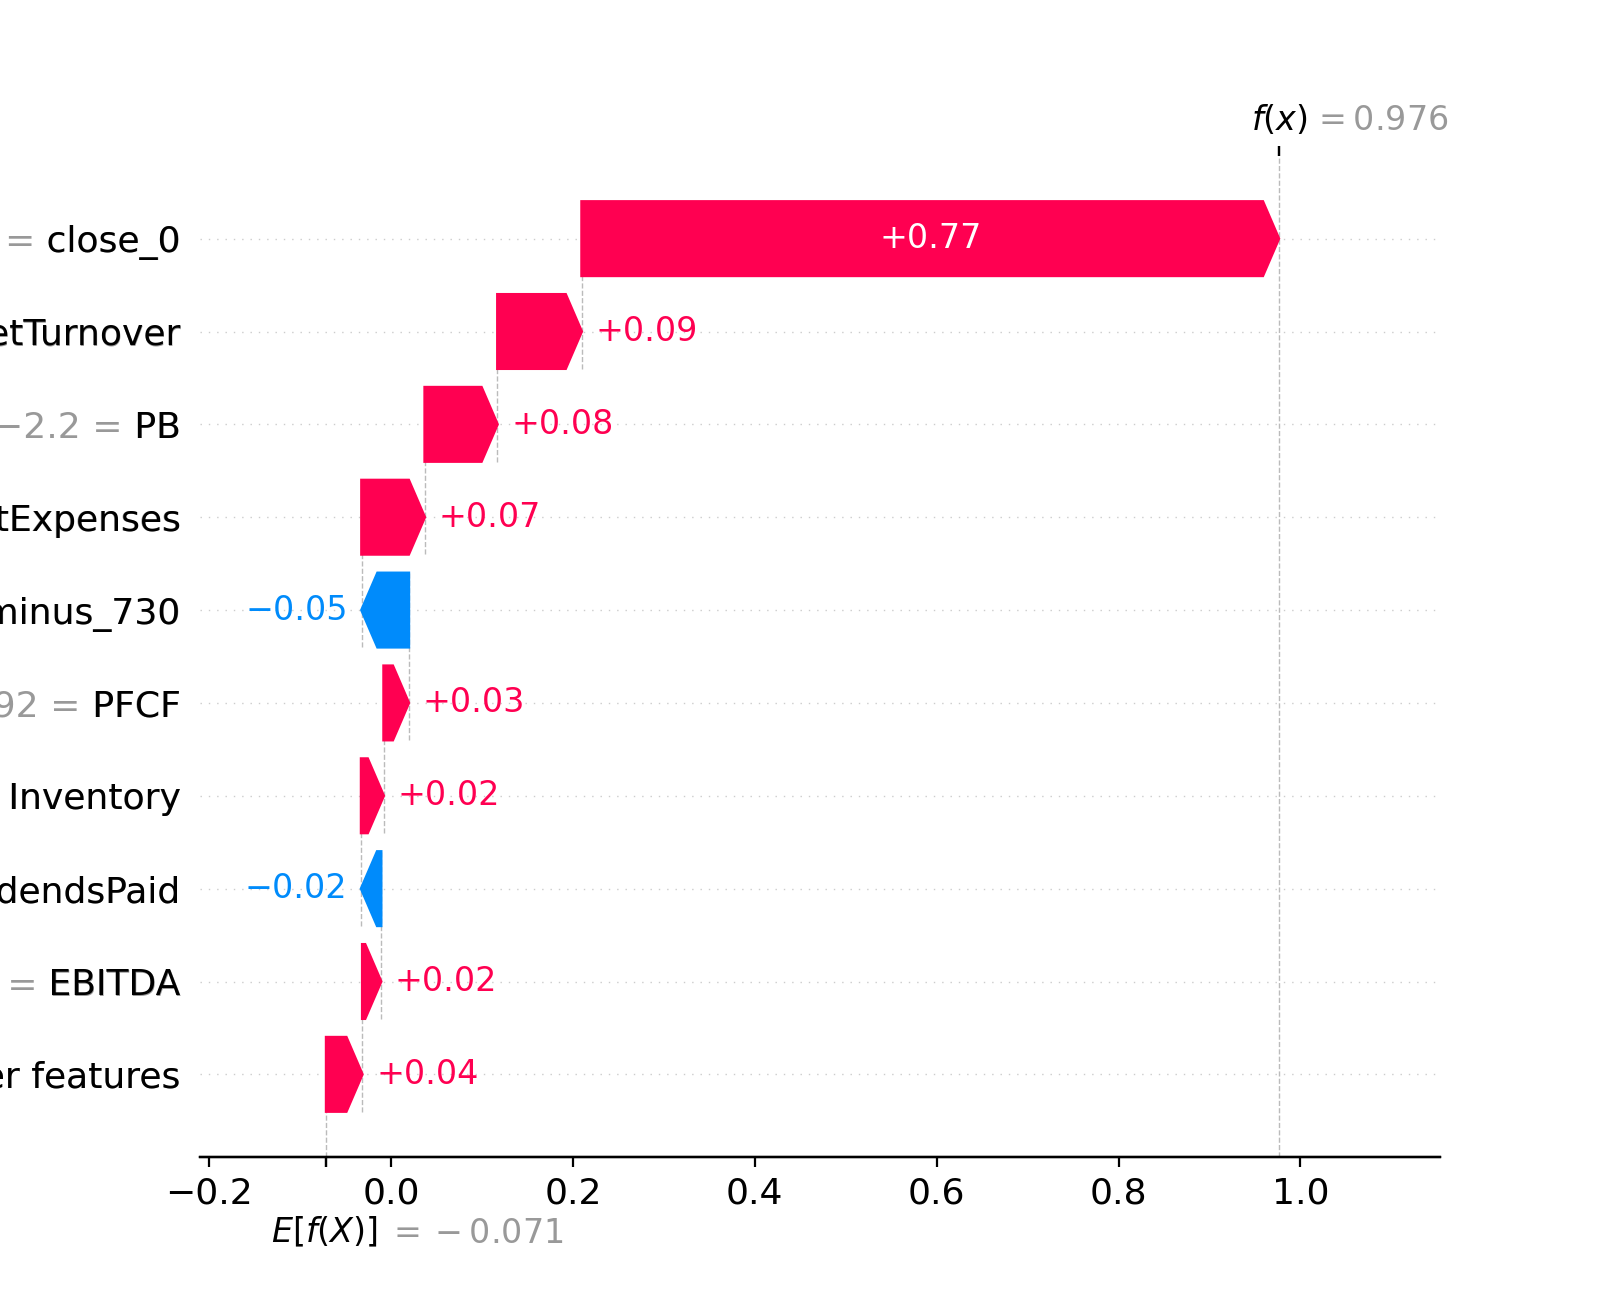

<Figure size 500x500 with 0 Axes>

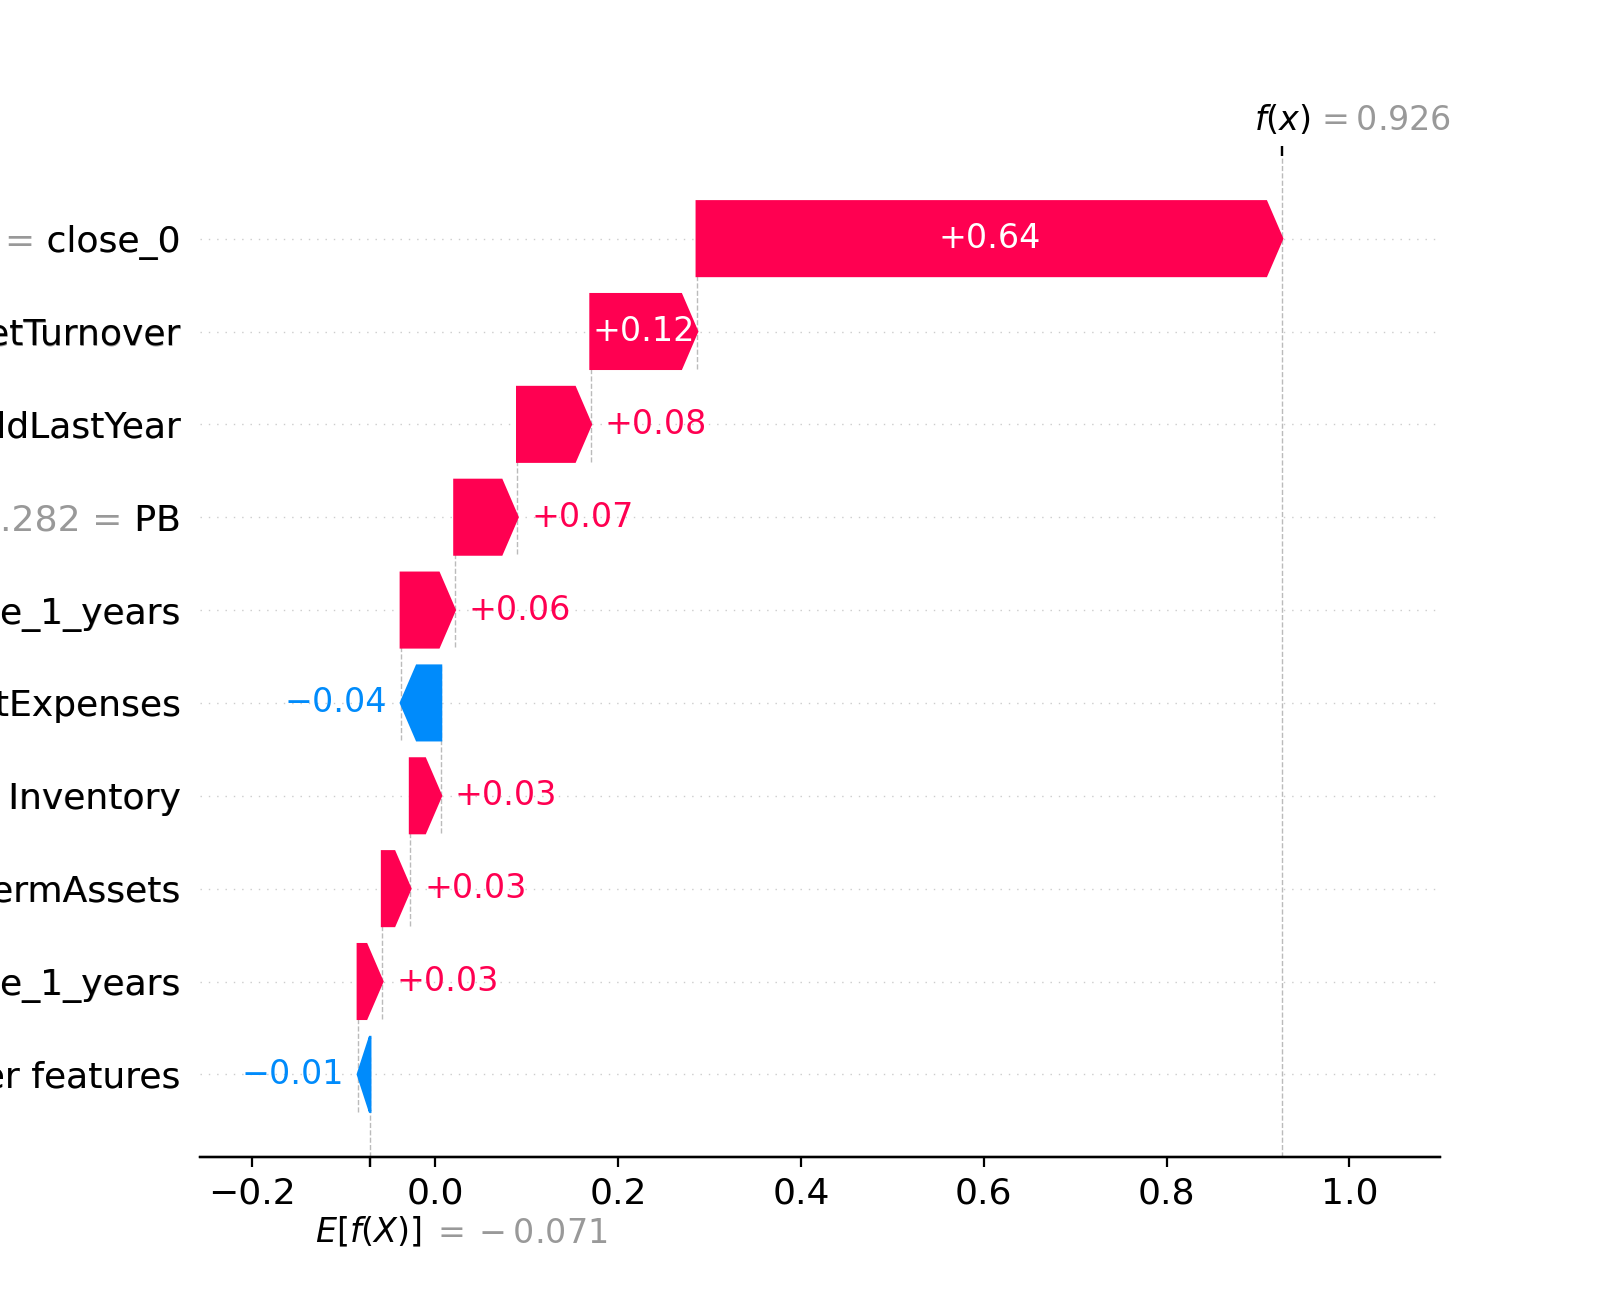

<Figure size 500x500 with 0 Axes>

In [414]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
for i in predicted_tickers.index[:3]:
    shap.plots.waterfall(shap_values[i], max_display=10, show=False)
    plt.figure(figsize=(5, 5))
    plt.show()


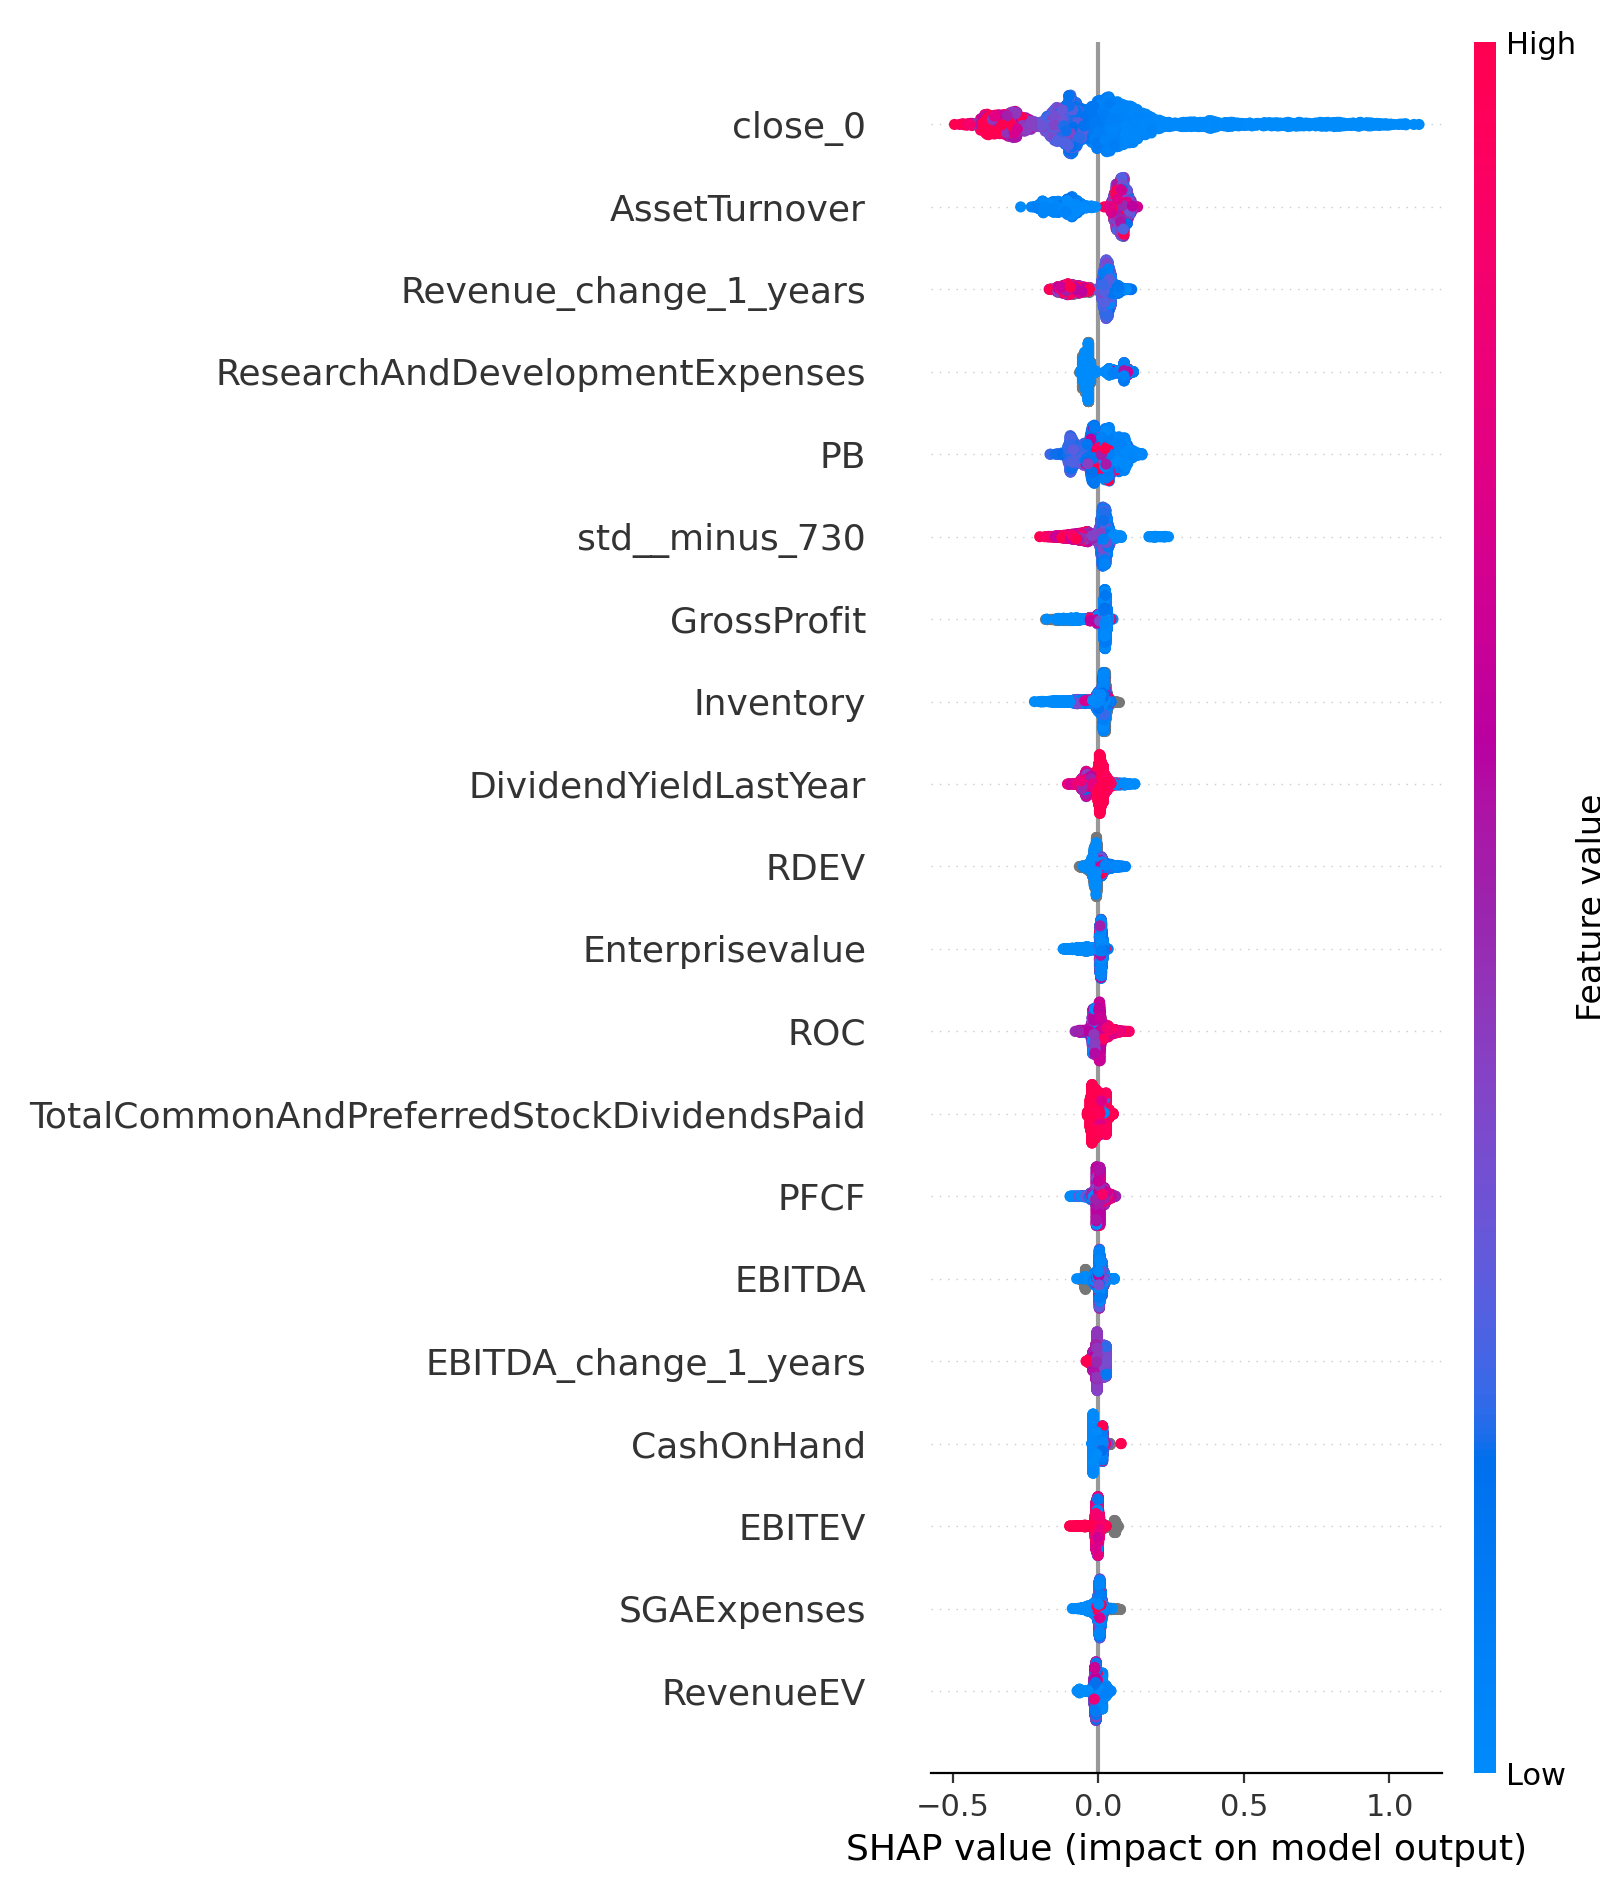

In [415]:
shap.summary_plot(shap_values, X_test)


In [416]:
predicted_tickers['target'][:10]

880     1.0
1893    0.0
3435    1.0
1790    1.0
2556    1.0
198     1.0
443     1.0
25      1.0
1923    0.0
922     1.0
Name: target, dtype: float64

In [426]:
execution_dates

array(['2005-06-30T00:00:00.000000000', '2005-09-30T00:00:00.000000000',
       '2005-12-30T00:00:00.000000000', '2006-03-31T00:00:00.000000000',
       '2006-06-30T00:00:00.000000000', '2006-09-30T00:00:00.000000000',
       '2006-12-30T00:00:00.000000000', '2007-03-31T00:00:00.000000000',
       '2007-06-30T00:00:00.000000000', '2007-09-30T00:00:00.000000000',
       '2007-12-30T00:00:00.000000000', '2008-03-31T00:00:00.000000000',
       '2008-06-30T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-12-30T00:00:00.000000000', '2009-03-31T00:00:00.000000000',
       '2009-06-30T00:00:00.000000000', '2009-09-30T00:00:00.000000000',
       '2009-12-30T00:00:00.000000000', '2010-03-31T00:00:00.000000000',
       '2010-06-30T00:00:00.000000000', '2010-09-30T00:00:00.000000000',
       '2010-12-30T00:00:00.000000000', '2011-03-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-30T00:00:00.000000000', '2012-03-31

In [432]:
evals_result,predicted_tickers,all_models,model,X_train,X_test = run_single_model_for_execution_date('2019-06-30T00:00:00.000000000',all_results,all_predicted_tickers_list,all_models,n_trees,False)
predicted_tickers['target'][:10]

91558
3408


1155    0.0
2214    0.0
2430    1.0
2249    1.0
2735    1.0
2642    1.0
1564    0.0
2538    1.0
2081    1.0
3242    1.0
Name: target, dtype: float64